We have:
$$
\nabla f = (I + \beta A) \vec s - \vec y
    = \vec s - \vec y + \beta A \vec s
$$ 
We can substitute in the partial derivatives:
$$ 
\left(\begin{matrix}
s_0 - y_0 + \beta (s_0 - s_1) \\
s_1 - y_1 + \beta (2s_1 - s_0 - s_2) \\
\vdots \\
s_N - y_N + \beta (s_N - s_{N - 1})
\end{matrix}\right) 
= \vec s - \vec y + \beta A \vec s
$$

Adding $\vec y - \vec s$ to both sides and then dividing by $\beta$ yields:
$$ 
\left(\begin{matrix}
s_0 - s_1 \\
2s_1 - s_0 - s_2 \\
\vdots \\
s_N - s_{N - 1}
\end{matrix}\right) 
= A \vec s
$$

Solving for $A$ is trivial and yields:
$$ 
A = \left(\begin{matrix}
1  & -1  &   &  &  &  &  \\
-1 & 2   & -1 &    & &     &  \\
  & -1  & 2  & -1 & &     &  \\
 & & \ddots & \ddots & \ddots & & \\
 &     & & -1 & 2  & -1 &  \\
 &     & &    & -1 & 2  & -1\\
  &  &  &  &  & -1 & 1
\end{matrix}\right) 
$$

In [3]:
import numpy as np
import modules.tridiagonal as tridiagonal

def sample_with_noise(points, vectorized_g):
  """
  Sample a function at a given set of points,
  introducing noise in the process.

  Returns a tuple of the real values of the function
  and the values with introduced noise.

  For performance reasons, this function takes in
  a vectorized version of `g`. If you want to pass
  a non vectorized function use `np.vectorize`. Eg:
  ```py
  sample_with_noise(points, np.vectorize(g))
  ```
  """
  gs = vectorized_g(points)
  ys = gs + 0.05 * np.random.randn(len(gs))

  return (gs, ys)

def p5(x):
  """
  Vectorized version of the function
  described in the pdf.
  """
  n = 5
  result = 0

  for k in range(n + 1):
    result += x**k

  return result/(n + 1)

def smooth(data, beta):
  """
  Smooth noisy data (y) by means of solving 
  a minimization problem.

  Args:
    data (numpy.array): noisy data to be smoothed (y)
    beta (float): parameter >= 0 that balances fit and smoothing

  Returns:
    numpy array of smoothed data (s)
  """
  x = data[0]
  y = data[1]

  # We need to solve for s in:
  #      (I + βA)s - y = 0
  #  <=> (I + βA)s = y
  #
  # Because A and I are tridiagonal, I + βA
  # is tridiagonal as well (linear combinations
  # of tridiagonal matrices are themselves
  # tridiagonal)
  #
  # This means we can use our existing implementation
  # of tridiagonal linear equation system solving.
  # 
  # We start by constructing 
  #   iba := I + βA
  n = len(x) - 1

  # The a component of the a-c-e tridiagonal representation of iba
  iba_a = np.ones(n + 1) * (2 * beta + 1)
  iba_a[0] = 1 + beta
  iba_a[-1] = 1 + beta

  # I + βA
  iba = (
    iba_a,
    -np.ones(n),
    -np.ones(n)
  )

  data_smoothed = tridiagonal.solve(*iba, y)

  return data_smoothed

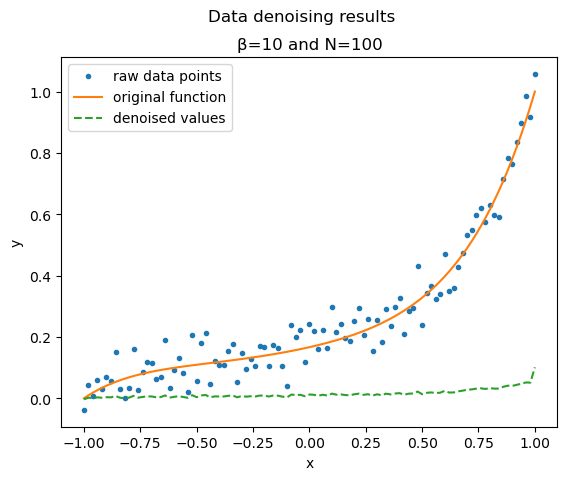

In [6]:
import matplotlib.pyplot as plot

# Reusable function to plot the data
def plot_denoise_results(β, N, ax):
  # Create the data
  x = np.linspace(-1, 1, num=N+1)
  g, y = sample_with_noise(x, p5)
  s = smooth((x, y), β)

  ax.set_title(f"{β=} and {N=}")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.plot(x, y, ".", label="raw data points")
  ax.plot(x, g, "-", label="original function")
  ax.plot(x, s, "--", label="denoised values")
  ax.legend()


N = 100
β = 10

fig, ax = plot.subplots()
fig.suptitle(f"Data denoising results")

# Plot the data
plot_denoise_results(β, N, ax)

We notice that finding a point where $\nabla f(s) = 0$ is the same as finding a point where $\frac 1 \beta \nabla f(s) = \nabla \frac 1 \beta f(s) = 0$. We can use this to our advantage, by defining $h(s) = \frac 1 \beta f(s)$ and finding the points where $\nabla h(s) = 0$ instead. When $\beta \to \infty$, we have:
$$
\lim_{\beta \to \inf} h _\beta (s) =
\lim_{\beta \to \inf} 
  \frac 1 {2\beta} \sum_{k=0}^n (y_k - s_k)^2
 +\frac 1 2 \sum_{k=1}^n (s_k - s_{k - 1})^2
 = \frac 1 2 \sum_{k=1}^n (s_k - s_{k - 1})^2
$$

It now becomes trivial to verify that $\nabla f(s) = As$, which means the solution to this will simply be the zero vector.

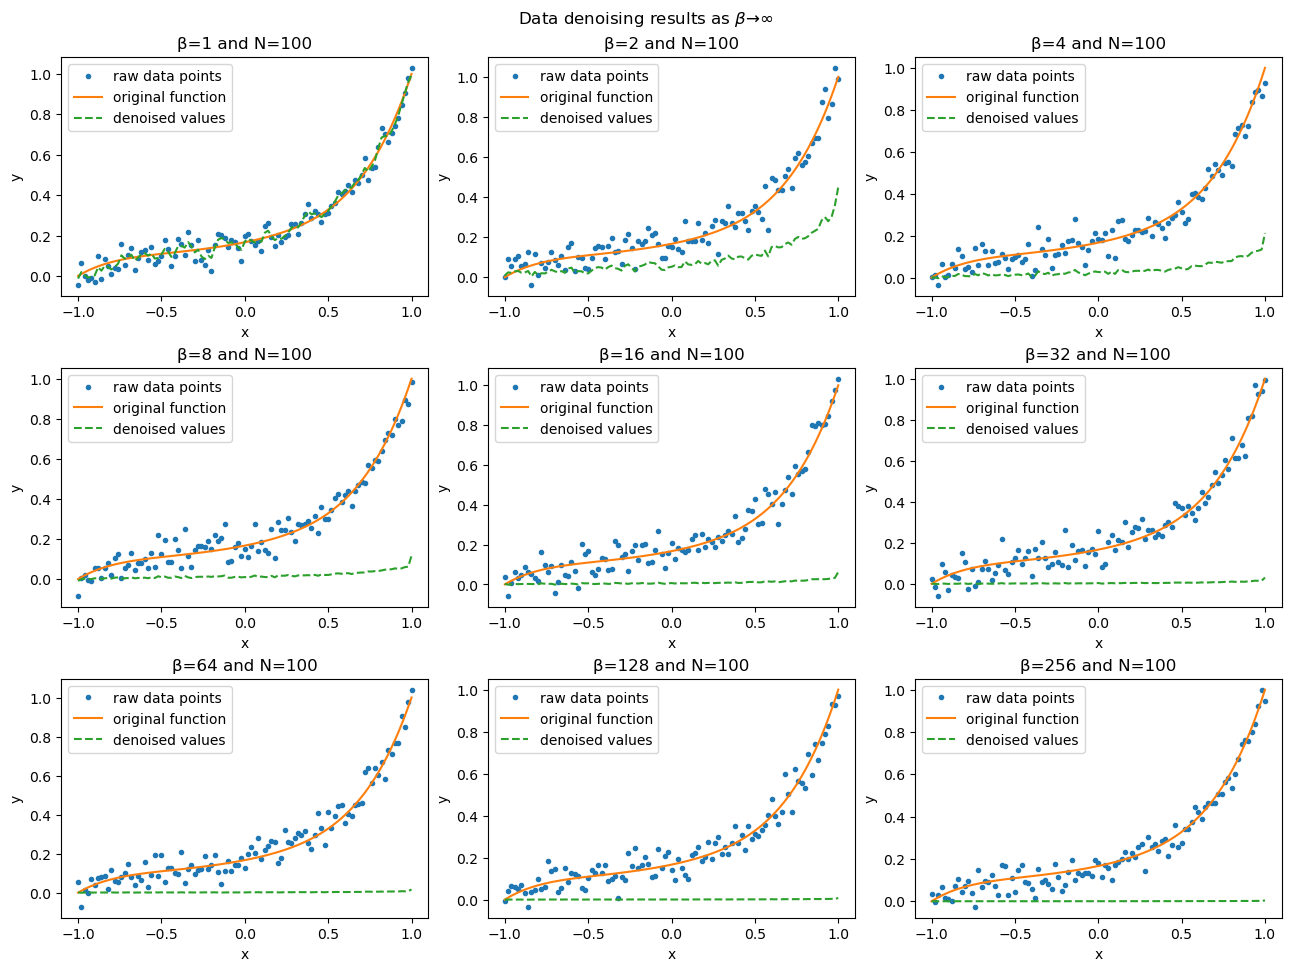

In [70]:
fig, axs = plot.subplots(
    3,
    3,
    layout="constrained",
    figsize=(12.8, 9.6)
)

fig.suptitle(r"Data denoising results as $\beta \to \infty$")

N = 100

for i in range(len(axs.flat)):
    ax = axs.flat[i]
    plot_denoise_results(2**i, N, ax)